In [1]:
import os
os.chdir('../')

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy


from research.utils import load_vocabulary, Tokenizer, Aligner
from research.scorer import Scorer
from research.greedy_optimizer import GreedyOptimizer
from research.beam_optimizer import BeamOptimizer

### Model loading

In [2]:
vocab = load_vocabulary()
tokenizer = Tokenizer()
scorer = Scorer()

### Translation scoring

In [3]:
english_sentence = 'I think, that machine translation is a very interesting subject.'
german_translation_from_google = 'Ich denke, dass maschinelle Übersetzung ein sehr interessantes Thema ist.'
score = scorer.score_texts(english_sentence, german_translation_from_google)
print('Translation scoring')
print('English sentence:', english_sentence)
print('Translation from google translate to score:', german_translation_from_google)
print('Log likehood of translation:', score[0])

Translation scoring
English sentence: I think, that machine translation is a very interesting subject.
Translation from google translate to score: Ich denke, dass maschinelle Übersetzung ein sehr interessantes Thema ist.
Log likehood of translation: -6.253188


### Predicting of next word in translation

In [4]:
unfinished_translation = 'Ich denke, dass maschinelle Übersetzung ein sehr'
english_tokens = tokenizer.tokenize(english_sentence)
german_tokens = tokenizer.tokenize(unfinished_translation)
next_word_probs = scorer.next_word_probabilities([english_tokens], [german_tokens])
val, ind = next_word_probs.topk(3)
print('English sentence:', english_sentence)
print('Unfinished translation:', unfinished_translation )
print('Top 3 next tokens: ', vocab.itos[ind[0,0].view(-1)], vocab.itos[ind[0,1].view(-1)], vocab.itos[ind[0,2].view(-1)])

English sentence: I think, that machine translation is a very interesting subject.
Unfinished translation: Ich denke, dass maschinelle Übersetzung ein sehr
Top 3 next tokens:  ▁interessante ▁interessant ▁Interessant


### Greedy optimization

In [5]:
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = GreedyOptimizer(english_sentence)
print('Optimizer initialized...')
german_tokens = optimizer.optimize()[:-1]
score = scorer.score_tokenized_texts([english_tokens], [german_tokens])[0]
print('English sentence:', english_sentence)
print('Translated tokens', ' '.join(german_tokens))
print(f'Log likehood of translation: {score:.2f}')

Optimizer initialized...
English sentence: I think, that machine translation is a very interesting subject.
Translated tokens ▁Ich ▁denke , ▁dass ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist .
Log likehood of translation: -5.41


### Beam search optimization

In [6]:
n_beams = 15
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: I think, that machine translation is a very interesting subject.
Top 15 translations:
1. ▁Ich ▁denke , ▁dass ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -5.41]
2. ▁Ich ▁glaube , ▁dass ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -5.74]
3. ▁Ich ▁halte ▁die ▁ maschine lle ▁Übersetzung ▁für ▁ein ▁sehr ▁interessante s ▁Thema . [p = -5.77]
4. ▁Ich ▁denke , ▁dass ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -6.25]
5. ▁Ich ▁glaube , ▁dass ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -6.65]
6. ▁Ich ▁finde , ▁dass ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -6.70]
7. ▁Ich ▁denke , ▁die ▁ maschine lle ▁Übersetzung ▁ist ▁ein ▁sehr ▁interessante s ▁Thema . [p = -6.87]
8. ▁Meine s ▁Era chtens ▁ist ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema . [p = -7.14]
9. ▁Ich ▁denke , ▁da

### Entropy of conditional probabilities for each word in different translations

In [7]:
def plot_entropies(i):
    plt.title('Entropy for each word in different translations')
    plt.xlabel('Word number')
    plt.ylabel('Entropy')
    trans = translations[i][:-1]
    logprobs = scorer.score_probabilities_for_each_word(english_tokens, trans)
    probs = np.exp(logprobs)
    words = list(range(probs.shape[0]))
    entropies = [entropy(probs[k, :]) for k in words]
    plt.scatter(words, entropies, label=f'Translation {i}')
    print(f'Translation {i}:\n{" | ".join(trans)}')
    print()
    plt.legend()

def plot_aligned_entropies(i, j):
    plt.title('Entropy for each word in different translations (aligned)')
    plt.xlabel('Word number')
    plt.ylabel('Entropy')
    
    aligner = Aligner()
    trans_i = translations[i][:-1]
    trans_j = translations[j][:-1]
    aligned_i, aligned_j = aligner.align(trans_i, trans_j)
    
    logprobs_i = scorer.score_probabilities_for_each_word(english_tokens, trans_i)
    probs_i = np.exp(logprobs_i)
    logprobs_j = scorer.score_probabilities_for_each_word(english_tokens, trans_j)
    probs_j = np.exp(logprobs_j)

    words = np.arange(len(aligned_i))
    entropies_i = []
    k = 0
    for word in aligned_i:
        if word == '[PLACEHOLDER]':
            entropies_i += [-1.]
        else:
            entropies_i += [entropy(probs_i[k, :])]
            k += 1
    entropies_i = np.array(entropies_i)
    
    entropies_j = []
    k = 0
    for word in aligned_j:
        if word == '[PLACEHOLDER]':
            entropies_j += [-1.]
        else:
            entropies_j += [entropy(probs_j[k, :])]
            k += 1
    entropies_j = np.array(entropies_j)
    
    plt.scatter(words[entropies_i >= 0.], entropies_i[entropies_i >= 0.], label=f'Translation {i}')
    plt.scatter(words[entropies_j >= 0.], entropies_j[entropies_j >= 0.], label=f'Translation {j}')
    print(f'Translation {i}:\n{" | ".join(aligned_i)}')
    print(f'Translation {j}:\n{" | ".join(aligned_j)}')
    print()
    plt.legend()
    
def plot_maxs(i):
    plt.title('Max for each word in different translations')
    plt.xlabel('Word number')
    plt.ylabel('Max')
    trans = translations[i][:-1]
    logprobs = scorer.score_probabilities_for_each_word(english_tokens, trans)
    probs = np.exp(logprobs)
    words = list(range(probs.shape[0]))
    entropies = [np.max(probs[k, :]) for k in words]
    plt.scatter(words, entropies, label=f'Translation {i}')
    print(f'Translation {i}:\n{" | ".join(trans)}')
    print()
    plt.legend()
    
def other_candidates(trans_idx, pos, N = 4):
    trans = translations[trans_idx][:-1]
    logprobs = scorer.score_probabilities_for_each_word(english_tokens, trans)
    probs = np.exp(logprobs)
    other_good_choices = np.argsort(probs[pos])[:-6:-1]
    print('Best candidates on position', pos, ': ', ' '.join([vocab.itos[idx] for idx in other_good_choices]))
    print('Coresponding probabilities:', [probs[pos][idx] for idx in other_good_choices])    

#### Comparison of the best and the worst translation

Translation 0:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .

Translation 9:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁Übersetzung | ▁von | ▁Maschinen | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



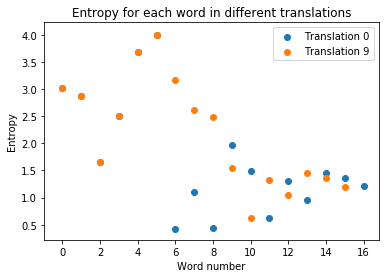

In [8]:
for i in [0, 9]:
    plot_entropies(i)
plt.show()

Translation 0:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .

Translation 9:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁Übersetzung | ▁von | ▁Maschinen | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



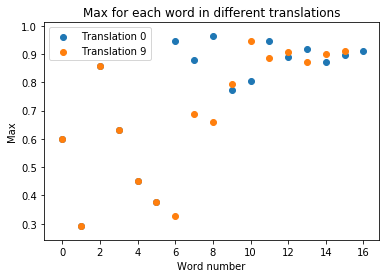

In [9]:
for i in [0, 9]:
    plot_maxs(i)
plt.show()

Entropia z jakiegoś powodu jest bardzo słabą miarą (chyba, że bug). Entropia dla pozycji 0 w zdaniu 9 niewiele różni się od entropi na pozycji 1 w zdaniu 9, a te rozkłady są zupełnie różne (na pozycji 0 mamy tylko 1 prawdopodobną wartość, a na pozycji 1 aż 4). Przykład poniżej:

#### Entropies of alligned sentences

Best vs worst translation:

Translation 0:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .
Translation 9:
▁Ich | ▁denke | , | ▁dass | ▁die | [PLACEHOLDER] | ▁Übersetzung | ▁von | ▁Maschinen | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



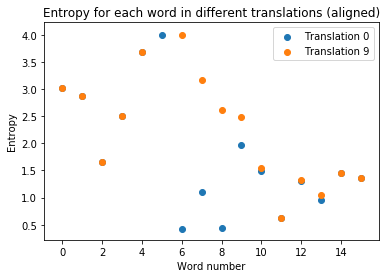

In [11]:
plot_aligned_entropies(0, 9)

Beam-10 vs Greedy translation:

Translation 0:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .
Translation 3:
▁Ich | ▁denke | , | ▁dass | [PLACEHOLDER] | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



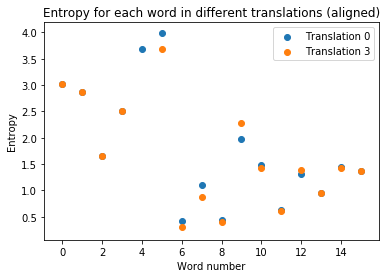

In [12]:
plot_aligned_entropies(0, 3)

Similar translations:

Translation 3:
▁Ich | ▁denke | , | ▁dass | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .
Translation 4:
▁Ich | ▁glaube | , | ▁dass | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



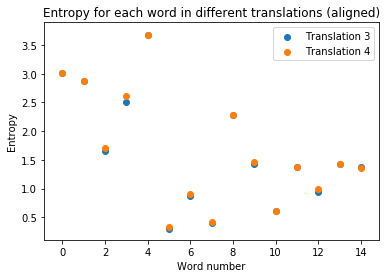

In [13]:
plot_aligned_entropies(3, 4)

In [14]:
other_candidates(9, 0)

Best candidates on position 0 :  ▁Ich ▁Das ▁Die ▁Meiner ▁Meine
Coresponding probabilities: [0.5988918, 0.060954917, 0.036728892, 0.024799734, 0.024179423]


In [152]:
other_candidates(9, 1)

Best candidates on position 1 :  ▁denke ▁glaube ▁halte ▁finde ▁bin
Coresponding probabilities: [0.29839528, 0.25234625, 0.13621552, 0.10573821, 0.043860655]


Zwróćmy też uwagę na niejednoznaczność tokenów: w miejscu, w którym wybieramy token _ prawdopodobieństwo jest małe, oraz entropia duża. Wynika to najprawdopodobniej z tego, że zamiast wybrać token _ , możemy wybrać cały token _ machinelle

### Other probable candidates

In [154]:
other_candidates(3, 1)

Best candidates on position 1 :  ▁denke ▁glaube ▁halte ▁finde ▁bin
Coresponding probabilities: [0.29839528, 0.25234625, 0.13621552, 0.10573821, 0.043860655]


In [153]:
other_candidates(3, 4)

Best candidates on position 4 :  ▁die ▁ ▁das ▁Maschinen ▁eine
Coresponding probabilities: [0.4021218, 0.112477794, 0.079811126, 0.05037697, 0.028617628]


In [155]:
other_candidates(3, 5)

Best candidates on position 5 :  ▁ ▁Übersetzung ▁Maschinen ▁technische ▁Maschinenbau
Coresponding probabilities: [0.4092544, 0.16365328, 0.06526854, 0.013711214, 0.0103740515]


In [156]:
other_candidates(3, 12)

Best candidates on position 12 :  . ▁Thema ▁Themen ▁Gegenstand ▁Subjekt
Coresponding probabilities: [0.45098555, 0.357347, 0.021454206, 0.005650598, 0.0052555017]


In [9]:
other_candidates(0, 5)

Best candidates on position 5 :  lle llen ll ller elle
Coresponding probabilities: [0.89663786, 0.026253838, 0.022556117, 0.012132816, 0.004152786]


In [15]:
other_candidates(0, 0)

Best candidates on position 0 :  ▁Ich ▁Das ▁Die ▁Meiner ▁Meine
Coresponding probabilities: [0.5988918, 0.060954917, 0.036728892, 0.024799734, 0.024179423]


### More difficult sentences:

In [3]:
n_beams = 30
english_sentence = 'Children begin by loving their parents; as they grow older they judge them; sometimes they forgive them.'
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: Children begin by loving their parents; as they grow older they judge them; sometimes they forgive them.
Top 30 translations:
1. ▁Kinder ▁beginnen ▁damit , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁verz eihen ▁sie ▁sie ▁ihnen . [p = -11.66]
2. ▁Kinder ▁beginnen ▁damit , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁vergeben ▁sie ▁ihnen . [p = -11.69]
3. ▁Kinder ▁lieben ▁ihre ▁Eltern ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁verz eihen ▁sie ▁sie ▁sie . [p = -11.72]
4. ▁Kinder ▁beginnen , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁vergeben ▁sie ▁ihnen . [p = -11.73]
5. ▁Kinder ▁beginnen , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁verz eihen ▁sie ▁sie ▁ihnen . [p = -11.83]
6. ▁Kinder ▁beginnen ▁damit , ▁ihre ▁Eltern ▁zu ▁liebe

In [4]:
n_beams = 1
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: Children begin by loving their parents; as they grow older they judge them; sometimes they forgive them.
Top 1 translations:
1. ▁Kinder ▁beginnen ▁damit , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁vergeben ▁sie ▁sie ▁ihnen . [p = -11.85]
Sanity check: log likehood of the best translation = -11.85


In [7]:
n_beams = 30
english_sentence = "There is always something ridiculous about the emotions of people whom one has ceased to love."
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: There is always something ridiculous about the emotions of people whom one has ceased to love.
Top 30 translations:
1. ▁Es ▁gibt ▁immer ▁etwas ▁Lä cherlich es ▁über ▁die ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -8.88]
2. ▁Es ▁ist ▁immer ▁etwas ▁Lä cherlich es ▁an ▁den ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -9.00]
3. ▁Es ▁gibt ▁immer ▁etwas ▁Lä cherlich es ▁an ▁den ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -9.06]
4. ▁Es ▁ist ▁immer ▁etwas ▁Lä cherlich es ▁über ▁die ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -9.08]
5. ▁Es ▁gibt ▁immer ▁etwas ▁Lä cherlich es ▁über ▁die ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁zu ▁lieben . [p = -9.32]
6. ▁Es ▁gibt ▁immer ▁etwas ▁Lä cherlich es ▁über ▁die ▁Gefühl e ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -9.35]
7. ▁Es ▁ist ▁immer ▁etwas ▁Lä cherlich

In [6]:
n_beams = 1
english_sentence = "There is always something ridiculous about the emotions of people whom one has ceased to love."
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: There is always something ridiculous about the emotions of people whom one has ceased to love.
Top 1 translations:
1. ▁Es ▁ist ▁immer ▁etwas ▁Lä cherlich es ▁an ▁den ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁nicht ▁mehr ▁lieben . [p = -9.60]
Sanity check: log likehood of the best translation = -9.60


In [3]:
n_beams = 10
english_sentence = "I count him braver who overcomes his desires than him who conquers his enemies; for the hardest victory is over self."
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: I count him braver who overcomes his desires than him who conquers his enemies; for the hardest victory is over self.
Top 10 translations:
1. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁der , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.36]
2. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁er , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.37]
3. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁der j en ige , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.54]
4. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et , ▁als ▁den , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.68]
5. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁er , ▁der ▁sei

In [8]:
n_beams = 1
english_sentence = "I count him braver who overcomes his desires than him who conquers his enemies; for the hardest victory is over self."
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: I count him braver who overcomes his desires than him who conquers his enemies; for the hardest victory is over self.
Top 1 translations:
1. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁der j en ige , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.54]
Sanity check: log likehood of the best translation = -9.54
